In [ ]:
!pip install astroquery

In [1]:
!pip install astropy_healpix

# 13.10 Scatter и Quiver

In [ ]:
import numpy as np
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [ ]:
Gaia.ROW_LIMIT = 50
coord = SkyCoord(ra='22h07m30.00s', dec='+00d43m00.4s', frame='icrs')
q_resutl = Gaia.cone_search_async(coord, radius=u.Quantity(0.5, u.deg),
                                  columns=["ra", "dec", "pmra", "pmdec", "phot_g_mean_mag"]).get_results()

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
ascii.write(q_resutl, "GAIA_table.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# q_resutl = ascii.read("GAIA_table.txt", delimiter="\t", format="commented_header",
#                       fill_values=[(ascii.masked, "nan")])

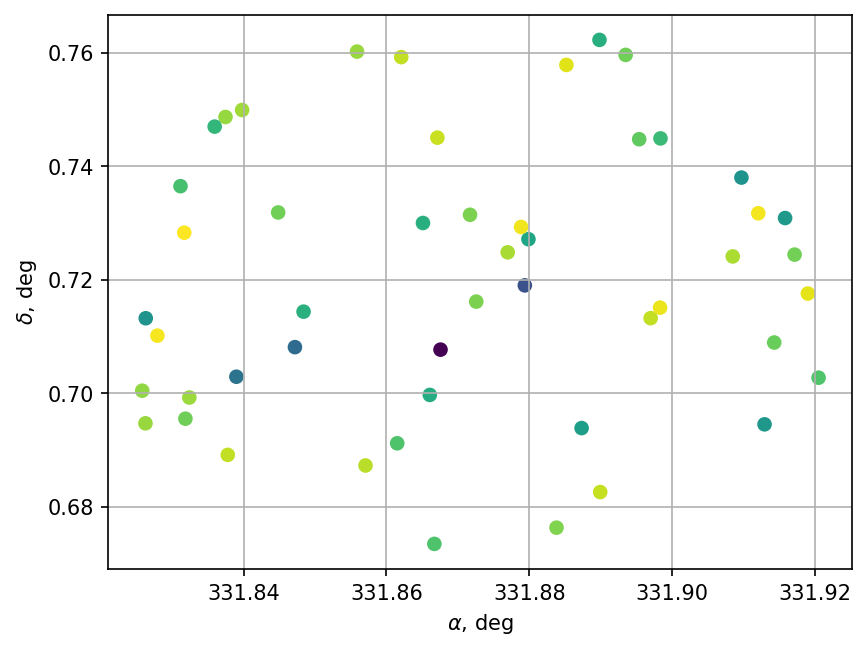

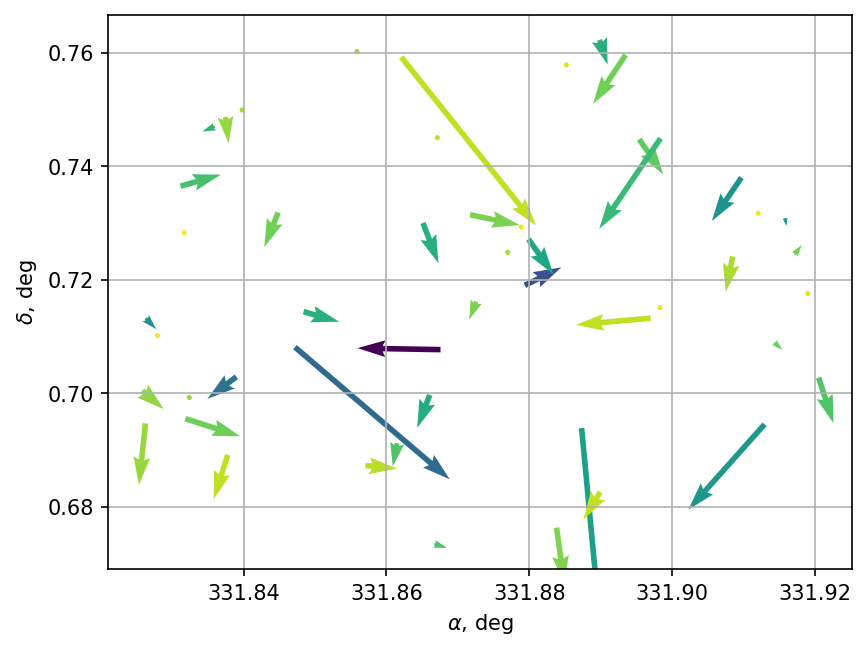

In [ ]:
fig1, ax1 = plt.subplots(dpi=150)
ax1.set_xlabel(r"$\alpha$, deg")
ax1.set_ylabel(r"$\delta$, deg")
ax1.grid()
msize = q_resutl["phot_g_mean_mag"]
ax1.scatter(q_resutl["ra"], q_resutl["dec"], c=q_resutl["phot_g_mean_mag"])
plt.savefig(f"result_scatter.png")


fig2, ax2 = plt.subplots(dpi=150)
ax2.set_xlabel(r"$\alpha$, deg")
ax2.set_ylabel(r"$\delta$, deg")
ax2.grid()
ax2.quiver(q_resutl["ra"].filled(0), q_resutl["dec"].filled(0), q_resutl["pmra"].filled(0), q_resutl["pmdec"].filled(0), q_resutl["phot_g_mean_mag"])
plt.savefig(f"result_quiver.png")

# 20.10 Xmatch

In [ ]:
"""
# Wavelengths are given in microns
# Zero-points are given in Vega-based system
# WISE - When the number of sightings is zero, the fluxes are set to the negative value of the sensitivity limit

[Cat. name] [Cat. VizieR des.]
    [Band name] [Band des.] [Peak wavelenth in micron] [Flux zero-point in Jy]

Gaia    I/355/gaiadr3
    G   Gmag    [mag]  0.622   3229
    BP  BPmag   [mag]  0.511   3552
    RP  RPmag   [mag]  0.777   2555
2MASS   II/246/out
    J   Jmag    [mag]   1.235   1594
    H   Hmag    [mag]   1.662   1024
    K   Kmag    [mag]   2.159   666.8
MSX6C   V/114/msx6_main | V/114/msx6_gp
    B1  -//-    [Jy]    4.29
    B2  -//-    [Jy]    4.25
    A   -//-    [Jy]    8.28
    C   -//-    [Jy]    12.13
    D   -//-    [Jy]    14.65
    E   -//-    [Jy]    21.34
WISE    II/311/wise
    W1  W1mag   [mag]   3.4     309.54
    W2  W2mag   [mag]   4.6     171.79
    W3  W3mag   [mag]   12      31.676
    W4  W4mag   [mag]   22      8.3635
Pan-STARRS  II/349/ps1
    g   gmag    [mag]   0.4866  3964.03
    r   rmag    [mag]   0.6215  3173.02
    i   imag    [mag]   0.7545  2575.36
    z   zmag    [mag]   0.8679  2261.81
    y   ymag    [mag]   0.9633  2180.40
"""

'\n# Wavelengths are given in microns\n# Zero-points are given in Vega-based system\n# WISE - When the number of sightings is zero, the fluxes are set to the negative value of the sensitivity limit\n\n[Cat. name] [Cat. VizieR des.]\n    [Band name] [Band des.] [Peak wavelenth in micron] [Flux zero-point in Jy]\n\nGaia    I/355/gaiadr3\n    G   Gmag    [mag]  0.622   3229\n    BP  BPmag   [mag]  0.511   3552\n    RP  RPmag   [mag]  0.777   2555\n2MASS   II/246/out\n    J   Jmag    [mag]   1.235   1594\n    H   Hmag    [mag]   1.662   1024\n    K   Kmag    [mag]   2.159   666.8\nMSX6C   V/114/msx6_main | V/114/msx6_gp\n    B1  -//-    [Jy]    4.29\n    B2  -//-    [Jy]    4.25\n    A   -//-    [Jy]    8.28\n    C   -//-    [Jy]    12.13\n    D   -//-    [Jy]    14.65\n    E   -//-    [Jy]    21.34\nWISE    II/311/wise\n    W1  W1mag   [mag]   3.4     309.54\n    W2  W2mag   [mag]   4.6     171.79\n    W3  W3mag   [mag]   12      31.676\n    W4  W4mag   [mag]   22      8.3635\nPan-STARRS 

In [ ]:
import numpy as np
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy.table import Table
from astropy.modeling import models
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Could not import regions, which is required for some of the functionalities of this module.


## Query region

In [ ]:
"GAIA"
qcoo = SkyCoord(ra='22h07m30.00s', dec='+00d43m00.4s', frame='icrs')
# qcoo = SkyCoord(ra='01h33m50.8965749232s', dec='+30d39m36.630403128s', frame='icrs')  # Zwicky test
qviz = Vizier(columns=["RAJ2000", "DEJ2000", "Gmag", "e_Gmag", "BPmag", "e_BPmag", "RPmag", "e_RPmag"])
qviz.ROW_LIMIT = -1

qres = qviz.query_region(qcoo, radius=u.Quantity(0.2, u.deg), catalog="I/355/gaiadr3")[0]
qres.sort("Gmag")
ascii.write(qres, "gaia.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# qres = ascii.read("gaia.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])

In [ ]:
"2MASS"
x2mass = XMatch.query(cat1=qres, cat2="vizier:II/246/out", max_distance=1 * u.arcsec,
                      colRA1="RAJ2000", colDec1="DEJ2000")
ascii.write(x2mass, "2mass.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# x2mass = ascii.read("2mass.txt", delimiter="\t", format="commented_header",
#                     fill_values=[(ascii.masked, "nan")])
qres["Jmag"] = np.nan
qres["e_Jmag"] = np.nan
qres["Hmag"] = np.nan
qres["e_Hmag"] = np.nan
qres["Kmag"] = np.nan
qres["e_Kmag"] = np.nan
for _ in range(len(x2mass)):
    for __ in range(len(qres)):
        if x2mass["RAJ2000_1"][_] == qres["RAJ2000"][__] and x2mass["DEJ2000_1"][_] == qres["DEJ2000"][__]:
            qres["Jmag"][__] = x2mass["Jmag"][_]
            qres["e_Jmag"][__] = x2mass["e_Jmag"][_]
            qres["Hmag"][__] = x2mass["Hmag"][_]
            qres["e_Hmag"][__] = x2mass["e_Hmag"][_]
            qres["Kmag"][__] = x2mass["Kmag"][_]
            qres["e_Kmag"][__] = x2mass["e_Kmag"][_]
    if _ % 10 == 0:
        print(f"Merging GAIA and 2MASS - {_} rows processed")
# qres = ascii.read("qres.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])

Merging GAIA and 2MASS - 0 rows processed
Merging GAIA and 2MASS - 10 rows processed
Merging GAIA and 2MASS - 20 rows processed
Merging GAIA and 2MASS - 30 rows processed
Merging GAIA and 2MASS - 40 rows processed
Merging GAIA and 2MASS - 50 rows processed
Merging GAIA and 2MASS - 60 rows processed
Merging GAIA and 2MASS - 70 rows processed
Merging GAIA and 2MASS - 80 rows processed
Merging GAIA and 2MASS - 90 rows processed
Merging GAIA and 2MASS - 100 rows processed
Merging GAIA and 2MASS - 110 rows processed
Merging GAIA and 2MASS - 120 rows processed
Merging GAIA and 2MASS - 130 rows processed


/usr/local/lib/python3.10/dist-packages/astropy/table/column.py:1362: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Merging GAIA and 2MASS - 140 rows processed
Merging GAIA and 2MASS - 150 rows processed
Merging GAIA and 2MASS - 160 rows processed
Merging GAIA and 2MASS - 170 rows processed
Merging GAIA and 2MASS - 180 rows processed
Merging GAIA and 2MASS - 190 rows processed
Merging GAIA and 2MASS - 200 rows processed
Merging GAIA and 2MASS - 210 rows processed
Merging GAIA and 2MASS - 220 rows processed
Merging GAIA and 2MASS - 230 rows processed
Merging GAIA and 2MASS - 240 rows processed
Merging GAIA and 2MASS - 250 rows processed
Merging GAIA and 2MASS - 260 rows processed
Merging GAIA and 2MASS - 270 rows processed
Merging GAIA and 2MASS - 280 rows processed
Merging GAIA and 2MASS - 290 rows processed
Merging GAIA and 2MASS - 300 rows processed
Merging GAIA and 2MASS - 310 rows processed
Merging GAIA and 2MASS - 320 rows processed
Merging GAIA and 2MASS - 330 rows processed


In [ ]:
"MSX6C"
xmsx6c = XMatch.query(cat1=qres, cat2="vizier:V/114/msx6_main", max_distance=1 * u.arcsec,
                      colRA1="RAJ2000", colDec1="DEJ2000")
ascii.write(xmsx6c, "msx6c.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# xmsx6c = ascii.read("msx6c.txt", delimiter="\t", format="commented_header",
#                     fill_values=[(ascii.masked, "nan")])
qres["B1"] = np.nan
qres["e_B1"] = np.nan
qres["B2"] = np.nan
qres["e_B2"] = np.nan
qres["A"] = np.nan
qres["e_A"] = np.nan
qres["C"] = np.nan
qres["e_C"] = np.nan
qres["D"] = np.nan
qres["e_D"] = np.nan
qres["E"] = np.nan
qres["e_E"] = np.nan
for _ in range(len(xmsx6c)):
    for __ in range(len(qres)):
        if xmsx6c["RAJ2000_1"][_] == qres["RAJ2000"][__] and xmsx6c["DEJ2000_1"][_] == qres["DEJ2000"][__]:
            qres["B1"][__] = xmsx6c["B1"][_]
            qres["e_B1"][__] = xmsx6c["e_B1"][_]
            qres["B2"][__] = xmsx6c["B2"][_]
            qres["e_B2"][__] = xmsx6c["e_B2"][_]
            qres["A"][__] = xmsx6c["A"][_]
            qres["e_A"][__] = xmsx6c["e_A"][_]
            qres["C"][__] = xmsx6c["C"][_]
            qres["e_C"][__] = xmsx6c["e_C"][_]
            qres["D"][__] = xmsx6c["D"][_]
            qres["e_D"][__] = xmsx6c["e_D"][_]
            qres["E"][__] = xmsx6c["E"][_]
            qres["e_E"][__] = xmsx6c["e_E"][_]
    if _ % 10 == 0:
        print(f"Merging GAIA and MSX6C - {_} rows processed")
# qres = ascii.read("qres.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])

In [ ]:
"WISE"
xwise = XMatch.query(cat1=qres, cat2="vizier:II/311/wise", max_distance=1 * u.arcsec,
                     colRA1="RAJ2000", colDec1="DEJ2000")
ascii.write(xwise, "wise.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# xwise = ascii.read("wise.txt", delimiter="\t", format="commented_header",
#                    fill_values=[(ascii.masked, "nan")])
qres["W1mag"] = np.nan
qres["e_W1mag"] = np.nan
qres["W2mag"] = np.nan
qres["e_W2mag"] = np.nan
qres["W3mag"] = np.nan
qres["e_W3mag"] = np.nan
qres["W4mag"] = np.nan
qres["e_W4mag"] = np.nan
for _ in range(len(xwise)):
    for __ in range(len(qres)):
        if xwise["RAJ2000"][_] == qres["RAJ2000"][__] and xwise["DEJ2000"][_] == qres["DEJ2000"][__]:
            qres["W1mag"][__] = xwise["W1mag"][_]
            qres["e_W1mag"][__] = xwise["e_W1mag"][_]
            qres["W2mag"][__] = xwise["W2mag"][_]
            qres["e_W2mag"][__] = xwise["e_W2mag"][_]
            qres["W3mag"][__] = xwise["W3mag"][_]
            qres["e_W3mag"][__] = xwise["e_W3mag"][_]
            qres["W4mag"][__] = xwise["W4mag"][_]
            qres["e_W4mag"][__] = xwise["e_W4mag"][_]
    if _ % 10 == 0:
        print(f"Merging GAIA and WISE - {_} rows processed")
# qres = ascii.read("qres.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])

Merging GAIA and WISE - 0 rows processed


/usr/local/lib/python3.10/dist-packages/astropy/table/column.py:1362: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Merging GAIA and WISE - 10 rows processed
Merging GAIA and WISE - 20 rows processed
Merging GAIA and WISE - 30 rows processed
Merging GAIA and WISE - 40 rows processed
Merging GAIA and WISE - 50 rows processed
Merging GAIA and WISE - 60 rows processed
Merging GAIA and WISE - 70 rows processed
Merging GAIA and WISE - 80 rows processed
Merging GAIA and WISE - 90 rows processed
Merging GAIA and WISE - 100 rows processed
Merging GAIA and WISE - 110 rows processed
Merging GAIA and WISE - 120 rows processed
Merging GAIA and WISE - 130 rows processed
Merging GAIA and WISE - 140 rows processed
Merging GAIA and WISE - 150 rows processed
Merging GAIA and WISE - 160 rows processed
Merging GAIA and WISE - 170 rows processed
Merging GAIA and WISE - 180 rows processed
Merging GAIA and WISE - 190 rows processed
Merging GAIA and WISE - 200 rows processed
Merging GAIA and WISE - 210 rows processed
Merging GAIA and WISE - 220 rows processed
Merging GAIA and WISE - 230 rows processed
Merging GAIA and WIS

In [ ]:
"Pan-STARRS"
xpan = XMatch.query(cat1=qres, cat2="vizier:II/349/ps1", max_distance=1 * u.arcsec,
                    colRA1="RAJ2000", colDec1="DEJ2000")
ascii.write(xpan, "pan.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# xpan = ascii.read("pan.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])
qres["gmag"] = np.nan
qres["e_gmag"] = np.nan
qres["rmag"] = np.nan
qres["e_rmag"] = np.nan
qres["imag"] = np.nan
qres["e_imag"] = np.nan
qres["zmag"] = np.nan
qres["e_zmag"] = np.nan
qres["ymag"] = np.nan
qres["e_ymag"] = np.nan
for _ in range(len(xpan)):
    for __ in range(len(qres)):
        if xpan["RAJ2000_1"][_] == qres["RAJ2000"][__] and xpan["DEJ2000_1"][_] == qres["DEJ2000"][__]:
            qres["gmag"][__] = xpan["gmag"][_]
            qres["e_gmag"][__] = xpan["e_gmag"][_]
            qres["rmag"][__] = xpan["rmag"][_]
            qres["e_rmag"][__] = xpan["e_rmag"][_]
            qres["imag"][__] = xpan["imag"][_]
            qres["e_imag"][__] = xpan["e_imag"][_]
            qres["zmag"][__] = xpan["zmag"][_]
            qres["e_zmag"][__] = xpan["e_zmag"][_]
            qres["ymag"][__] = xpan["ymag"][_]
            qres["e_ymag"][__] = xpan["e_ymag"][_]
    if _ % 10 == 0:
        print(f"Merging GAIA and Pan-STARRS - {_} rows processed")
ascii.write(qres, "qres.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])

/usr/local/lib/python3.10/dist-packages/astropy/table/column.py:1362: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Merging GAIA and Pan-STARRS - 0 rows processed
Merging GAIA and Pan-STARRS - 10 rows processed
Merging GAIA and Pan-STARRS - 20 rows processed
Merging GAIA and Pan-STARRS - 30 rows processed
Merging GAIA and Pan-STARRS - 40 rows processed
Merging GAIA and Pan-STARRS - 50 rows processed
Merging GAIA and Pan-STARRS - 60 rows processed
Merging GAIA and Pan-STARRS - 70 rows processed
Merging GAIA and Pan-STARRS - 80 rows processed
Merging GAIA and Pan-STARRS - 90 rows processed
Merging GAIA and Pan-STARRS - 100 rows processed
Merging GAIA and Pan-STARRS - 110 rows processed
Merging GAIA and Pan-STARRS - 120 rows processed
Merging GAIA and Pan-STARRS - 130 rows processed
Merging GAIA and Pan-STARRS - 140 rows processed
Merging GAIA and Pan-STARRS - 150 rows processed
Merging GAIA and Pan-STARRS - 160 rows processed
Merging GAIA and Pan-STARRS - 170 rows processed
Merging GAIA and Pan-STARRS - 180 rows processed
Merging GAIA and Pan-STARRS - 190 rows processed
Merging GAIA and Pan-STARRS - 2

## Convert magnitudes to flux

In [ ]:
qres = ascii.read("qres.txt", delimiter="\t", format="commented_header",
                  fill_values=[(ascii.masked, "nan")])
fres = Table()
fres["RAJ2000"] = qres["RAJ2000"]
fres["DEJ2000"] = qres["DEJ2000"]

"Gaia"
fres["f_G"] = 3229 * 10 ** (-0.4 * qres["Gmag"])
fres["e_G"] = fres["f_G"] * 0.4 * np.log(10) * qres["e_Gmag"]
fres["f_BP"] = 3552 * 10 ** (-0.4 * qres["BPmag"])
fres["e_BP"] = fres["f_BP"] * 0.4 * np.log(10) * qres["e_BPmag"]
fres["f_RP"] = 2555 * 10 ** (-0.4 * qres["RPmag"])
fres["e_RP"] = fres["f_RP"] * 0.4 * np.log(10) * qres["e_RPmag"]

"2MASS"
fres["f_J"] = 1594 * 10 ** (-0.4 * qres["Jmag"])
fres["e_J"] = fres["f_J"] * 0.4 * np.log(10) * qres["e_Jmag"]
fres["f_H"] = 1024 * 10 ** (-0.4 * qres["Hmag"])
fres["e_H"] = fres["f_H"] * 0.4 * np.log(10) * qres["e_Hmag"]
fres["f_K"] = 666.8 * 10 ** (-0.4 * qres["Kmag"])
fres["e_K"] = fres["f_K"] * 0.4 * np.log(10) * qres["e_Kmag"]

"MSX6C"
fres["f_B1"] = qres["B1"]
fres["e_B1"] = fres["f_B1"] * qres["e_B1"] / 100
fres["f_B2"] = qres["B2"]
fres["e_B2"] = fres["f_B2"] * qres["e_B2"] / 100
fres["f_A"] = qres["A"]
fres["e_A"] = fres["f_A"] * qres["e_A"] / 100
fres["f_C"] = qres["C"]
fres["e_C"] = fres["f_C"] * qres["e_C"] / 100
fres["f_D"] = qres["D"]
fres["e_D"] = fres["f_D"] * qres["e_D"] / 100
fres["f_E"] = qres["E"]
fres["e_E"] = fres["f_E"] * qres["e_E"] / 100

"WISE"
fres["f_W1"] = 309.54 * 10 ** (-0.4 * qres["W1mag"])
fres["e_W1"] = fres["f_W1"] * 0.4 * np.log(10) * qres["e_W1mag"]
fres["f_W2"] = 171.79 * 10 ** (-0.4 * qres["W2mag"])
fres["e_W2"] = fres["f_W2"] * 0.4 * np.log(10) * qres["e_W2mag"]
fres["f_W3"] = 31.676 * 10 ** (-0.4 * qres["W3mag"])
fres["e_W3"] = fres["f_W3"] * 0.4 * np.log(10) * qres["e_W3mag"]
fres["f_W4"] = 8.3635 * 10 ** (-0.4 * qres["W4mag"])
fres["e_W4"] = fres["f_W4"] * 0.4 * np.log(10) * qres["e_W4mag"]

"Pan-STARRS"
fres["f_g"] = 3964.03 * 10 ** (-0.4 * qres["gmag"])
fres["e_g"] = fres["f_g"] * 0.4 * np.log(10) * qres["e_gmag"]
fres["f_r"] = 3173.02 * 10 ** (-0.4 * qres["rmag"])
fres["e_r"] = fres["f_r"] * 0.4 * np.log(10) * qres["e_rmag"]
fres["f_i"] = 2575.36 * 10 ** (-0.4 * qres["imag"])
fres["e_i"] = fres["f_i"] * 0.4 * np.log(10) * qres["e_imag"]
fres["f_z"] = 2261.81 * 10 ** (-0.4 * qres["zmag"])
fres["e_z"] = fres["f_z"] * 0.4 * np.log(10) * qres["e_zmag"]
fres["f_y"] = 2180.40 * 10 ** (-0.4 * qres["ymag"])
fres["e_y"] = fres["f_y"] * 0.4 * np.log(10) * qres["e_ymag"]

ascii.write(fres, "fres.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])

## Fit Plank function

In [ ]:
def planck(wavelen, temp, dilution):
    bb_model = models.BlackBody(temperature=temp * u.K)
    flux = bb_model(wavelen * u.um).to(u.Jy/u.sr) * np.pi * dilution
    return flux.value

In [ ]:
# fres = ascii.read("fres.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])
fres["p_temp"] = np.nan
fres["p_dil"] = np.nan
wavelengths = [0.622, 0.511, 0.777,  # Gaia
               1.235, 1.662, 2.159,  # 2MASS
               4.29, 4.25, 8.28, 12.13, 14.65, 21.34,  # MSX6C
               3.4, 4.6, 12, 22,  # WISE
               0.4866, 0.6215, 0.7545, 0.8679, 0.9633]  # Pan-STARRS
for _ in range(len(fres)):
    fluxes = [fres["f_G"][_], fres["f_BP"][_], fres["f_RP"][_],
              fres["f_J"][_], fres["f_H"][_], fres["f_K"][_],
              fres["f_B1"][_], fres["f_B2"][_], fres["f_A"][_], fres["f_C"][_], fres["f_D"][_], fres["f_E"][_],
              fres["f_W1"][_], fres["f_W2"][_], fres["f_W3"][_], fres["f_W4"][_],
              fres["f_g"][_], fres["f_r"][_], fres["f_i"][_], fres["f_z"][_], fres["f_y"][_]]
    popt = curve_fit(planck, wavelengths, fluxes,
                     p0=(5000, 1e-20), bounds=([2000, 1e-23], [8000, 1e-18]), nan_policy="omit")[0]
    fres["p_temp"][_] = popt[0]
    fres["p_dil"][_] = popt[1]
    if _ % 10 == 0:
        print(f"Fitting Planck function - {_} rows processed")
ascii.write(fres, "fres_fit.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])

Fitting Planck function - 0 rows processed
Fitting Planck function - 10 rows processed
Fitting Planck function - 20 rows processed
Fitting Planck function - 30 rows processed
Fitting Planck function - 40 rows processed
Fitting Planck function - 50 rows processed
Fitting Planck function - 60 rows processed


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting Planck function - 70 rows processed
Fitting Planck function - 80 rows processed
Fitting Planck function - 90 rows processed
Fitting Planck function - 100 rows processed
Fitting Planck function - 110 rows processed
Fitting Planck function - 120 rows processed
Fitting Planck function - 130 rows processed
Fitting Planck function - 140 rows processed
Fitting Planck function - 150 rows processed
Fitting Planck function - 160 rows processed
Fitting Planck function - 170 rows processed
Fitting Planck function - 180 rows processed
Fitting Planck function - 190 rows processed
Fitting Planck function - 200 rows processed
Fitting Planck function - 210 rows processed
Fitting Planck function - 220 rows processed
Fitting Planck function - 230 rows processed
Fitting Planck function - 240 rows processed
Fitting Planck function - 250 rows processed
Fitting Planck function - 260 rows processed
Fitting Planck function - 270 rows processed
Fitting Planck function - 280 rows processed
Fitting Planc

## Plot results

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


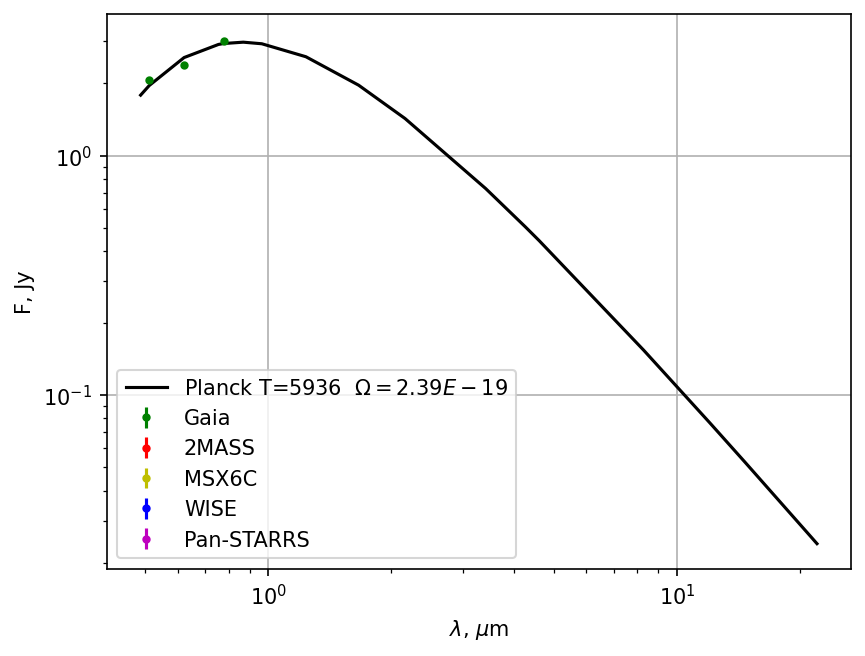

Plotting results - 0 rows processed


<Figure size 640x480 with 0 Axes>

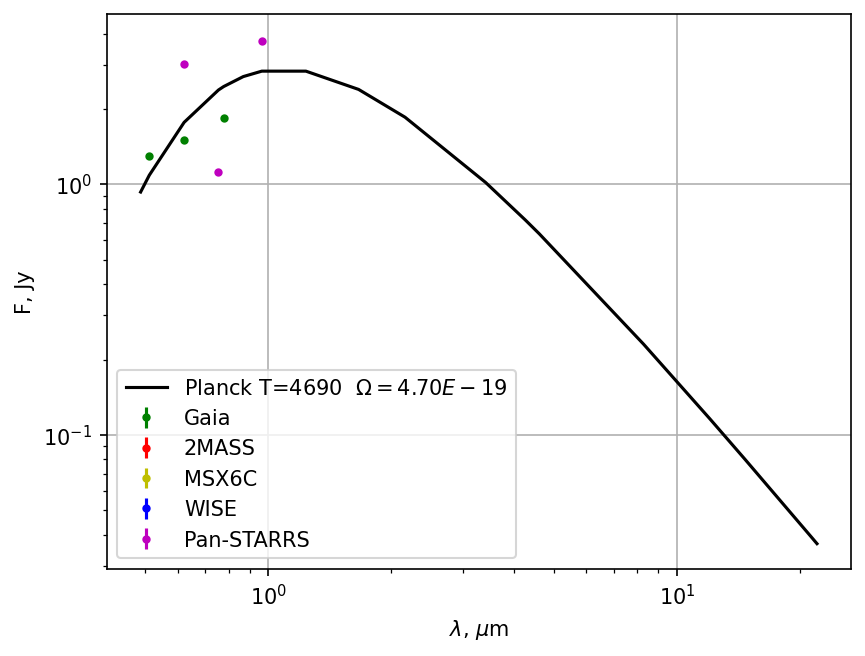

<Figure size 640x480 with 0 Axes>

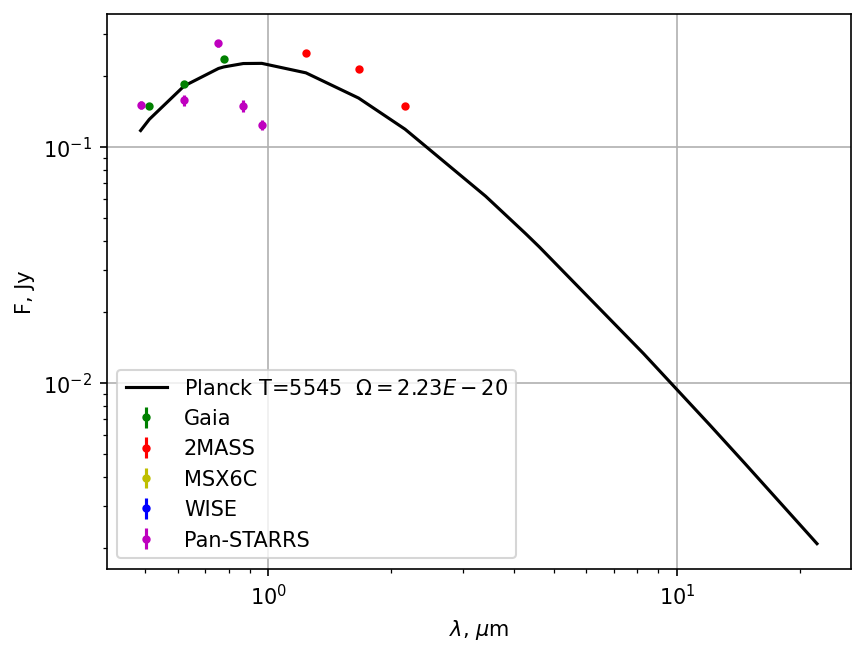

<Figure size 640x480 with 0 Axes>

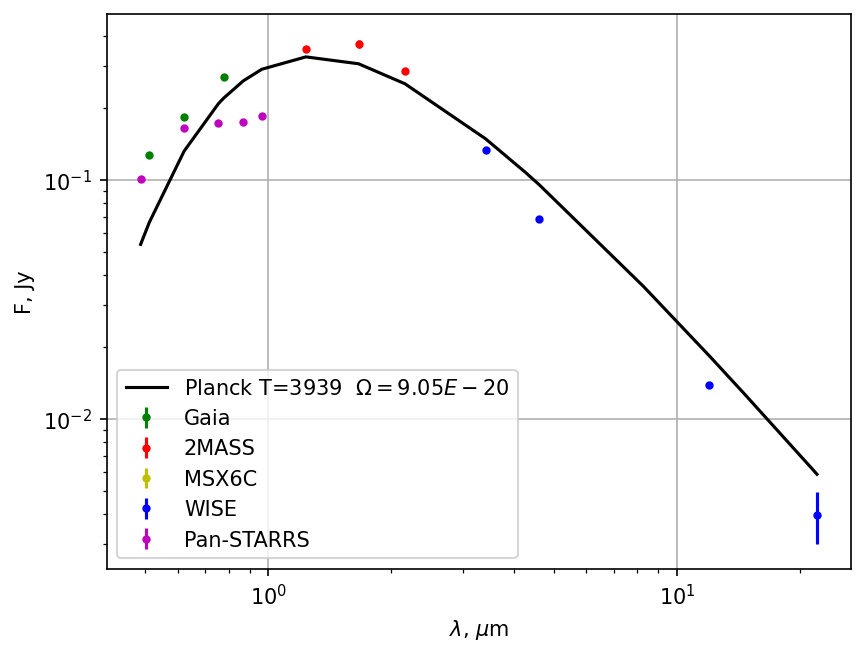

<Figure size 640x480 with 0 Axes>

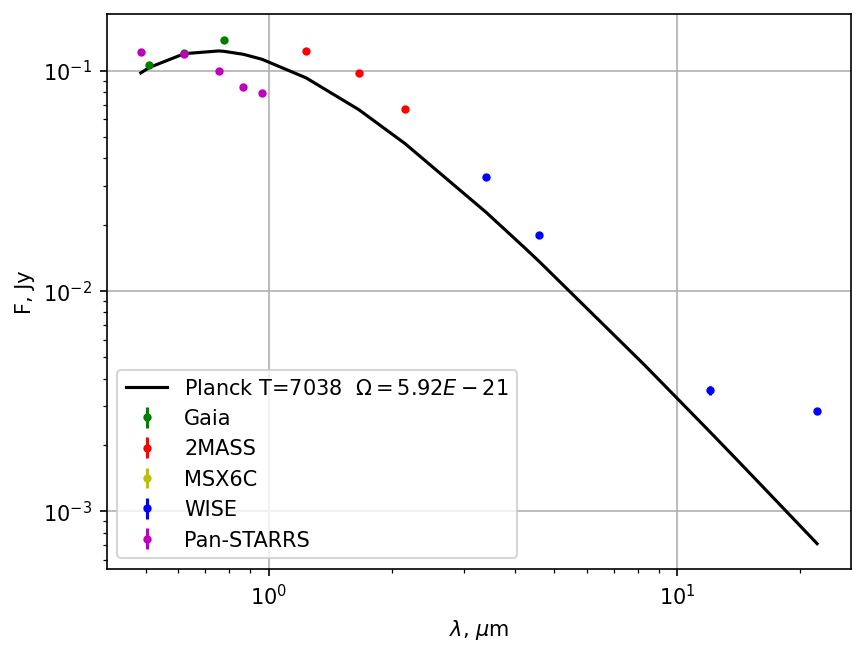

<Figure size 640x480 with 0 Axes>

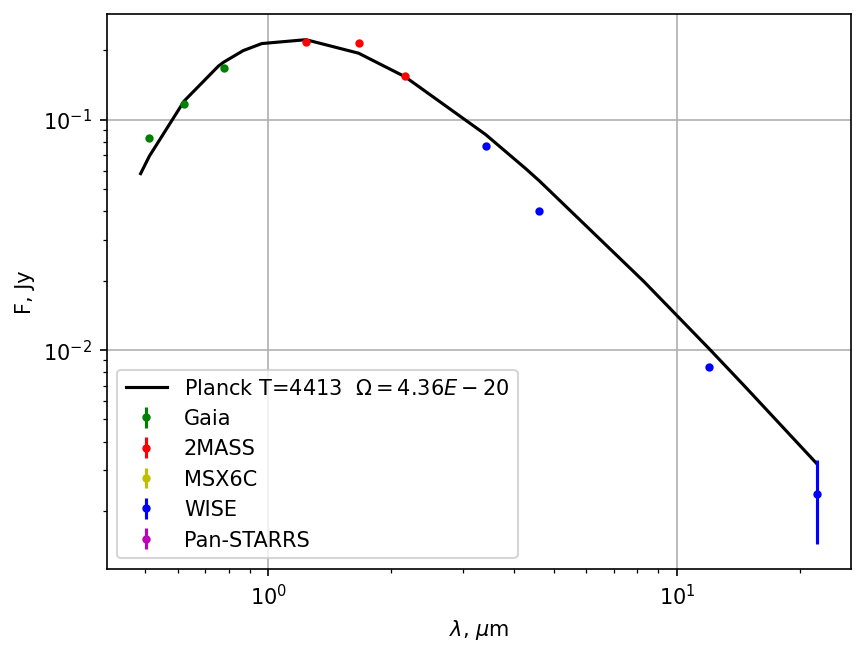

<Figure size 640x480 with 0 Axes>

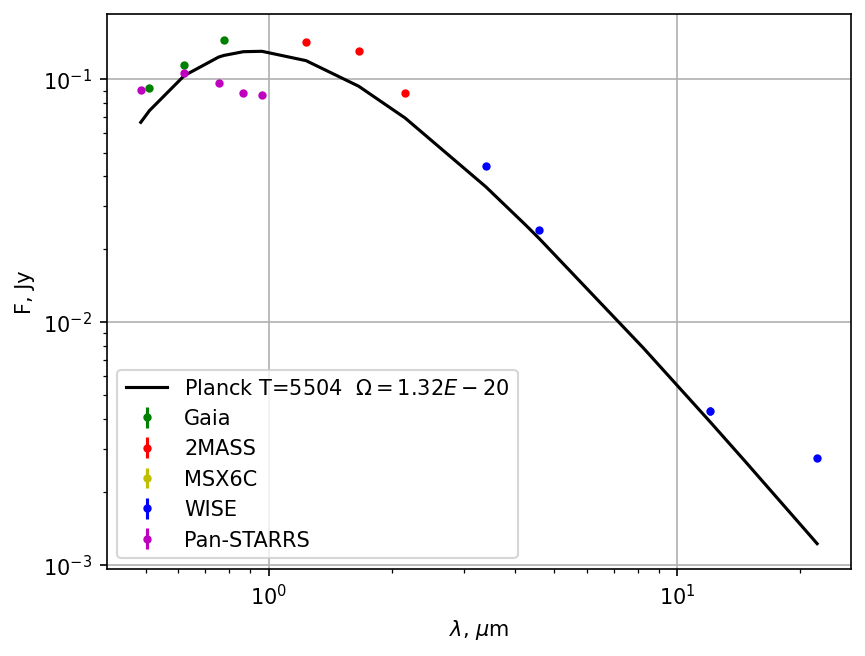

<Figure size 640x480 with 0 Axes>

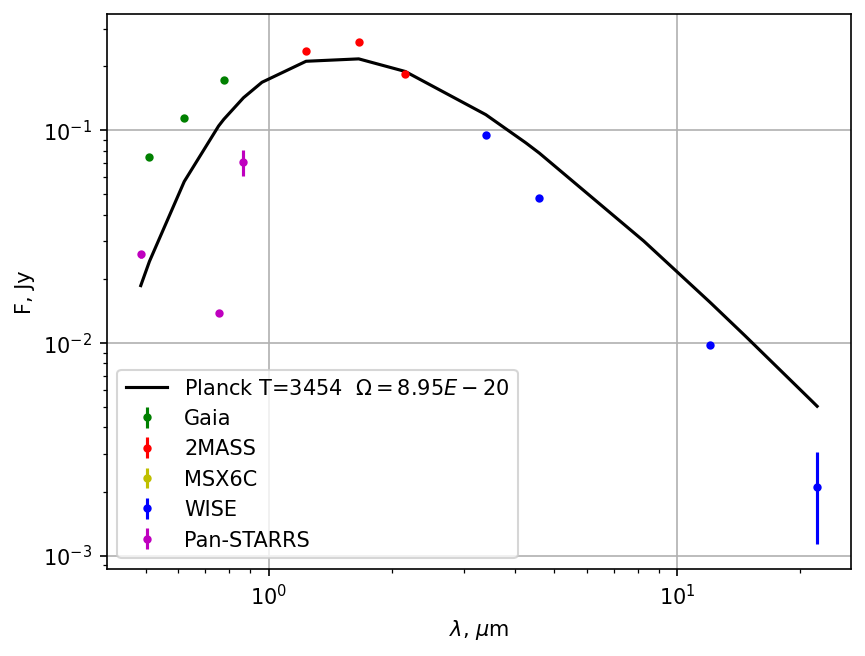

<Figure size 640x480 with 0 Axes>

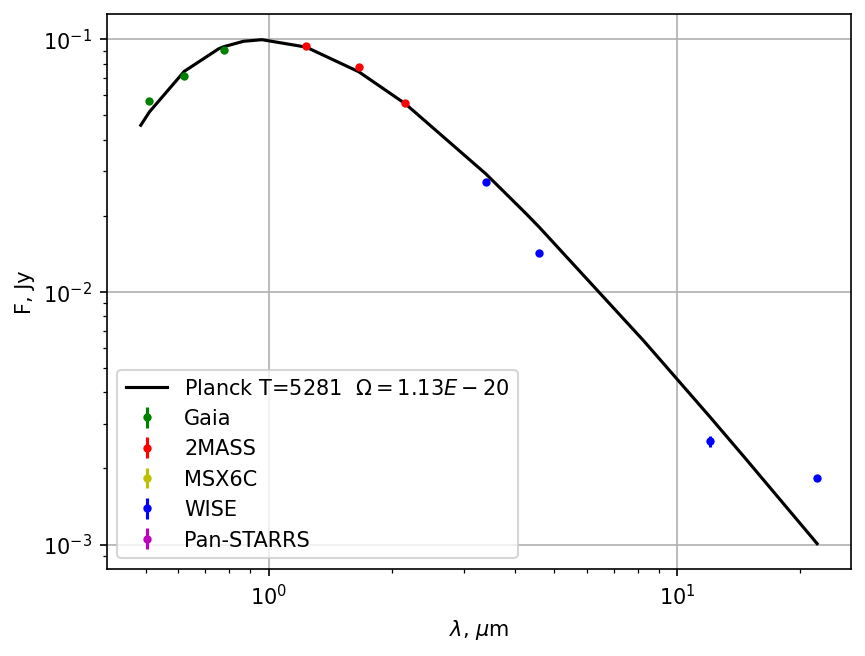

<Figure size 640x480 with 0 Axes>

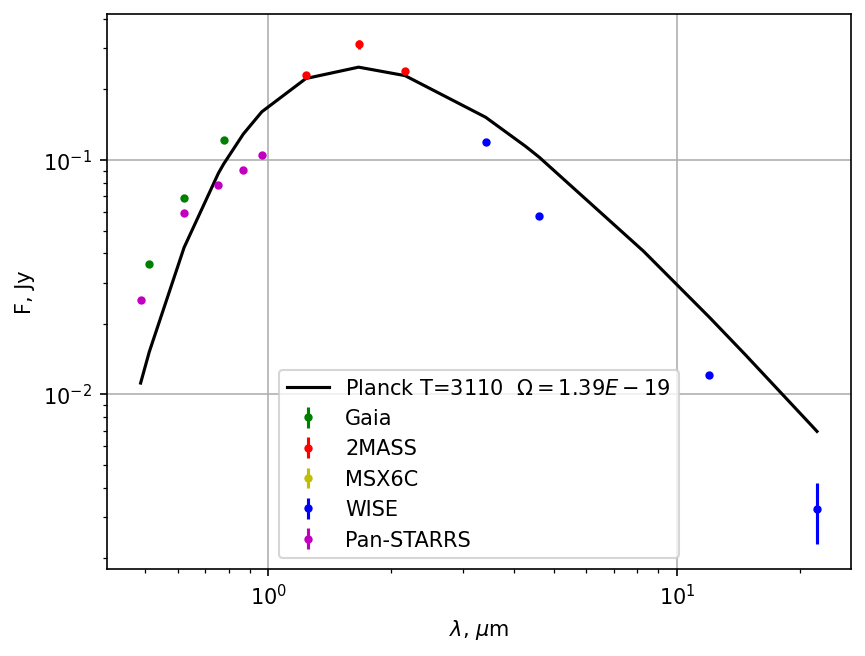

<Figure size 640x480 with 0 Axes>

In [ ]:
# fres = ascii.read("fres_fit.txt", delimiter="\t", format="commented_header",
#                   fill_values=[(ascii.masked, "nan")])
# wavelengths = [0.622, 0.511, 0.777,  # Gaia
#                1.235, 1.662, 2.159,  # 2MASS
#                4.29, 4.25, 8.28, 12.13, 14.65, 21.34,  # MSX6C
#                3.4, 4.6, 12, 22,  # WISE
#                0.4866, 0.6215, 0.7545, 0.8679, 0.9633]  # Pan-STARRS
wavelengths_sorted = np.sort(wavelengths)
for _ in range(10):
    fig, ax = plt.subplots(dpi=150)

    "Planck"
    ax.plot(wavelengths_sorted, planck(wavelengths_sorted, fres["p_temp"][_], fres["p_dil"][_]),
            "-k", label=f"Planck T={fres['p_temp'][_]:.0f}  $\\Omega={fres['p_dil'][_]:.2E}$")

    "Gaia"
    ax.errorbar(0.622, fres["f_G"][_], yerr=fres["e_G"][_], fmt=".g", label="Gaia")
    ax.errorbar(0.511, fres["f_BP"][_], yerr=fres["e_BP"][_], fmt=".g")
    ax.errorbar(0.777, fres["f_RP"][_], yerr=fres["e_RP"][_], fmt=".g")

    "2MASS"
    ax.errorbar(1.235, fres["f_J"][_], yerr=fres["e_J"][_], fmt=".r", label="2MASS")
    ax.errorbar(1.662, fres["f_H"][_], yerr=fres["e_H"][_], fmt=".r")
    ax.errorbar(2.159, fres["f_K"][_], yerr=fres["e_K"][_], fmt=".r")

    "MSX6C"
    ax.errorbar(4.29, fres["f_B1"][_], yerr=fres["e_B1"][_], fmt=".y", label="MSX6C")
    ax.errorbar(4.25, fres["f_B2"][_], yerr=fres["e_B2"][_], fmt=".y")
    ax.errorbar(8.28, fres["f_A"][_], yerr=fres["e_A"][_], fmt=".y")
    ax.errorbar(12.13, fres["f_C"][_], yerr=fres["e_C"][_], fmt=".y")
    ax.errorbar(14.65, fres["f_D"][_], yerr=fres["e_D"][_], fmt=".y")
    ax.errorbar(21.34, fres["f_E"][_], yerr=fres["e_E"][_], fmt=".y")

    "WISE"
    ax.errorbar(3.4, fres["f_W1"][_], yerr=fres["e_W1"][_], fmt=".b", label="WISE")
    ax.errorbar(4.6, fres["f_W2"][_], yerr=fres["e_W2"][_], fmt=".b")
    ax.errorbar(12, fres["f_W3"][_], yerr=fres["e_W3"][_], fmt=".b")
    ax.errorbar(22, fres["f_W4"][_], yerr=fres["e_W4"][_], fmt=".b")

    "Pan-STARRS"
    ax.errorbar(0.4866, fres["f_g"][_], yerr=fres["e_g"][_], fmt=".m", label="Pan-STARRS")
    ax.errorbar(0.6215, fres["f_r"][_], yerr=fres["e_r"][_], fmt=".m")
    ax.errorbar(0.7545, fres["f_i"][_], yerr=fres["e_i"][_], fmt=".m")
    ax.errorbar(0.8679, fres["f_z"][_], yerr=fres["e_z"][_], fmt=".m")
    ax.errorbar(0.9633, fres["f_y"][_], yerr=fres["e_y"][_], fmt=".m")

    ax.set_xlabel("$\\lambda$, $\\mu$m")
    ax.set_ylabel("F, Jy")
    ax.loglog()
    ax.grid()
    ax.legend()
    plt.show()
    plt.savefig(f"result_plot_{_:05d}.png")
    plt.close(fig=fig)

    if _ % 10 == 0:
        print(f"Plotting results - {_} rows processed")

# 03.11 SkyView и plt.hist

In [ ]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.io import ascii
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView

In [ ]:
skyv = SkyView()
hduls = skyv.get_images(position="Alpha Cancri", radius=5 * u.arcmin,
                        survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
for _ in range(len(hduls)):
    hduls[_].writeto(f"W{_+1} image.fits")


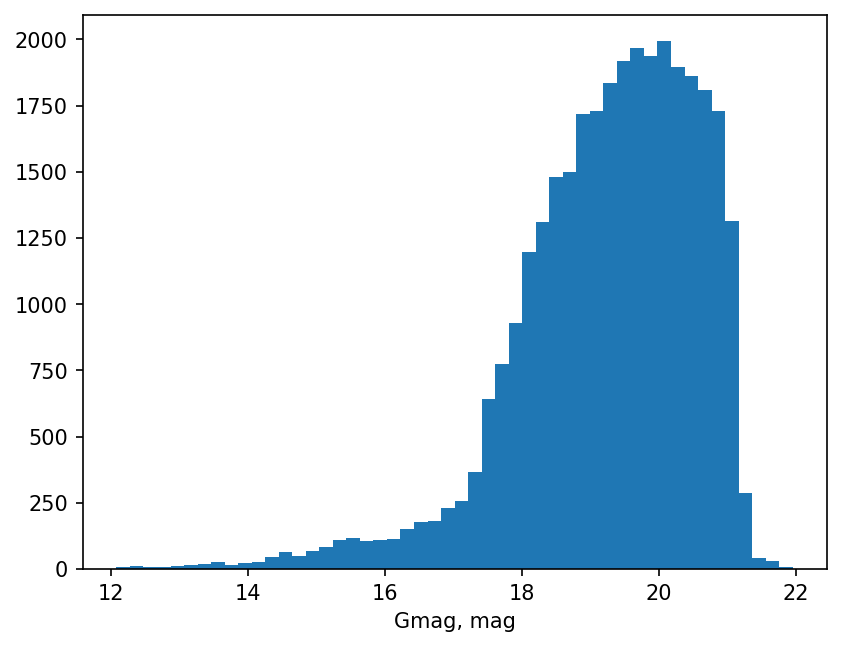

<Figure size 640x480 with 0 Axes>

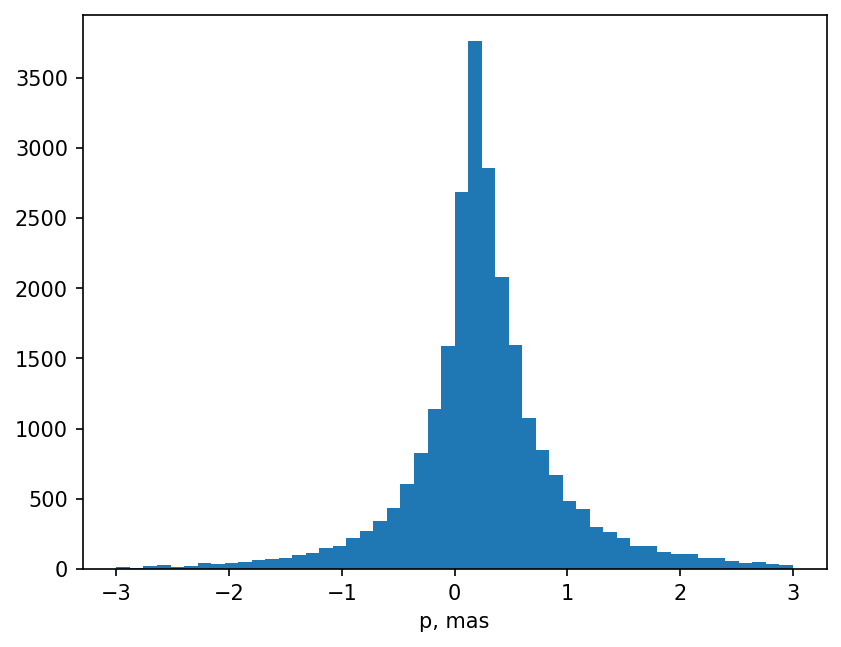

<Figure size 640x480 with 0 Axes>

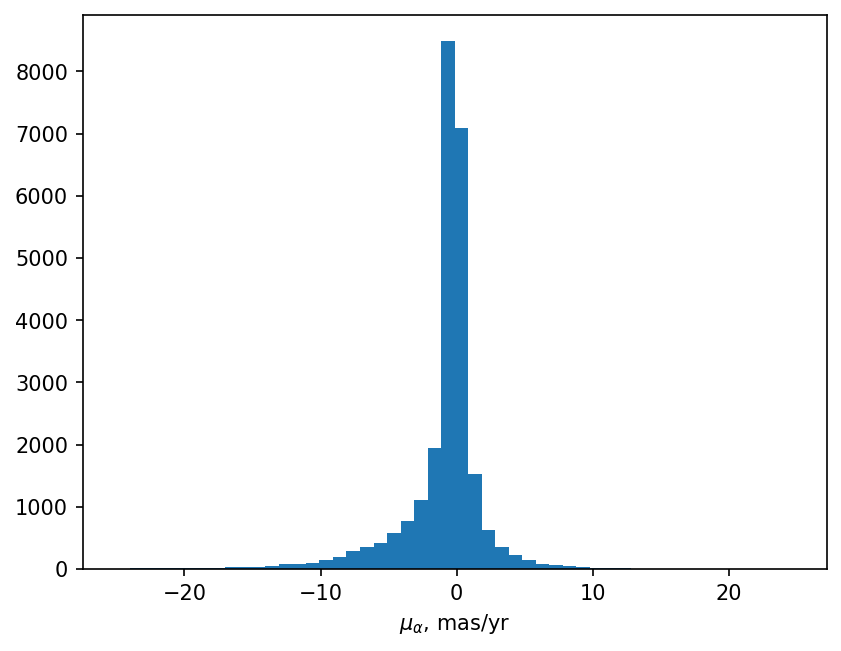

<Figure size 640x480 with 0 Axes>

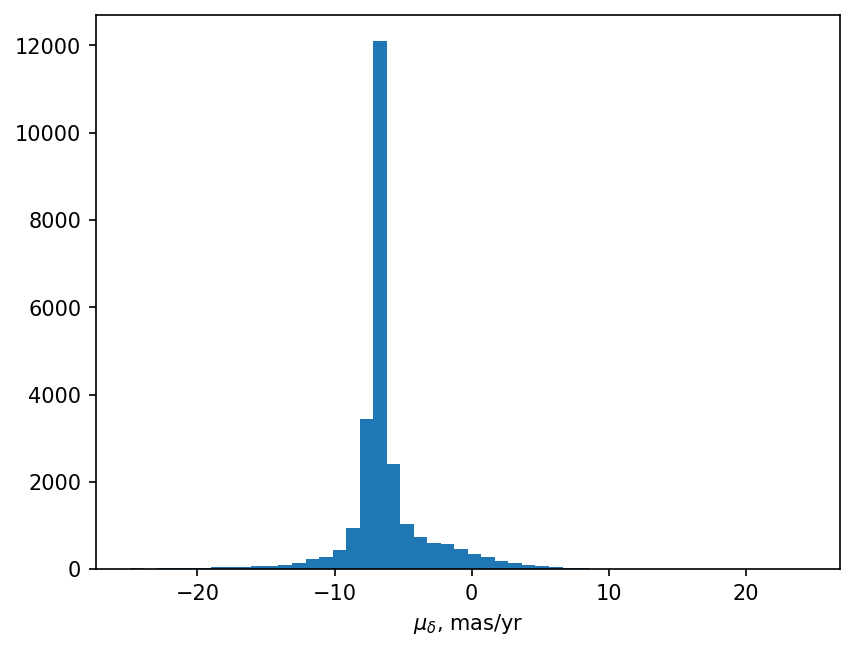

<Figure size 640x480 with 0 Axes>

In [ ]:
qviz_gc = Vizier(columns=["pmRA", "pmDE", "Plx", "Gmag"])
qviz_gc.ROW_LIMIT = -1
qres_gc = qviz_gc.query_region("M12", radius=20 * u.arcmin, catalog="I/355/gaiadr3")[0]
ascii.write(qres_gc, "qres_gc.txt", overwrite=True, delimiter="\t",
            format="commented_header", fill_values=[(ascii.masked, "nan")])
# qres_gc = ascii.read("qres_gc.txt", delimiter="\t", format="commented_header",
#                      fill_values=[(ascii.masked, "nan")])

"G magnitude"
fig, ax = plt.subplots(dpi=150)
x_gmag = qres_gc["Gmag"][np.where((qres_gc["Gmag"] > 12) & (qres_gc["Gmag"] < 22))]
ax.hist(x_gmag, bins=50)
ax.set_xlabel("Gmag, mag")
plt.show()
plt.savefig(f"Hist_Gmag.png")
plt.close(fig=fig)

"Parallax"
fig, ax = plt.subplots(dpi=150)
x_plx = qres_gc["Plx"][np.where((qres_gc["Plx"] > -3) & (qres_gc["Plx"] < 3))]
ax.hist(x_plx, bins=50)
ax.set_xlabel("p, mas")
plt.show()
plt.savefig(f"Hist_Plx.png")
plt.close(fig=fig)

"Proper motion - RA"
fig, ax = plt.subplots(dpi=150)
x_pmra = qres_gc["pmRA"][np.where((qres_gc["pmRA"] > -25) & (qres_gc["pmRA"] < 25))]
ax.hist(x_pmra, bins=50)
ax.set_xlabel("$\\mu_\\alpha$, mas/yr")
plt.show()
plt.savefig(f"Hist_pmRA.png")
plt.close(fig=fig)

"Proper motion - DEC"
fig, ax = plt.subplots(dpi=150)
x_pmde = qres_gc["pmDE"][np.where((qres_gc["pmDE"] > -25) & (qres_gc["pmDE"] < 25))]
ax.hist(x_pmde, bins=50)
ax.set_xlabel("$\\mu_\\delta$, mas/yr")
plt.show()
plt.savefig(f"Hist_pmDE.png")
plt.close(fig=fig)

# 15.11 HEALpix

In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy_healpix import HEALPix
from scipy.interpolate import griddata

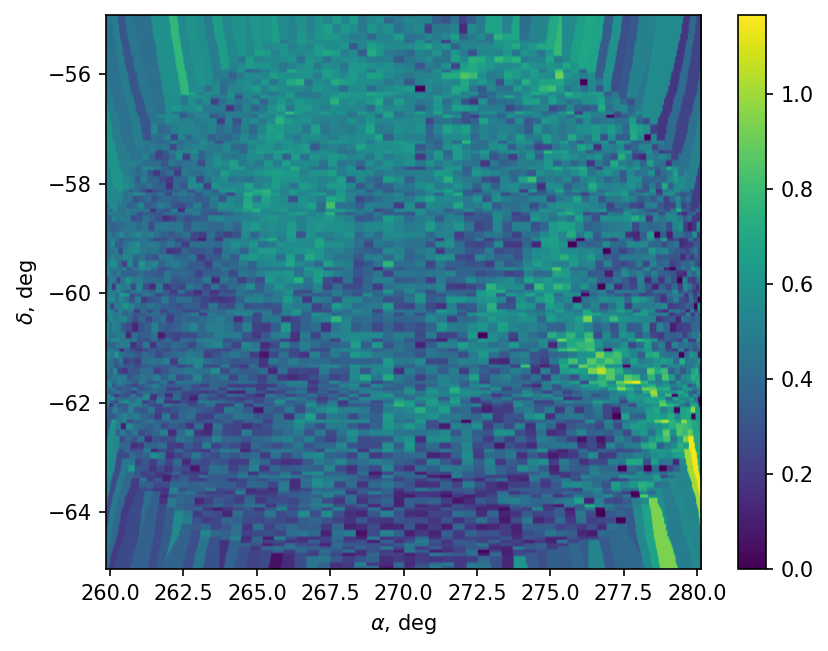

In [3]:
# Note: Due to griddata interpolation and HEALpix projection, the edges of the image are very ugly.
# This can be corrected by cutting off values beyond the target_rad, but I am not eager to do this.
lvl = 9
target_ra = 270 * u.deg
target_dec = -60 * u.deg
target_rad = 5 * u.deg
target_sc = SkyCoord(ra=target_ra, dec=target_dec, frame="icrs")


# archive = np.load("I_355_tgextmap.npz")
archive = np.load("/content/I_355_tgextmap.npz")
total_hpid = archive["HPId"]
total_a0 = archive["A0"]

hp = HEALPix(nside=2**lvl, order="nested", frame="icrs")
search_hpid = hp.cone_search_skycoord(target_sc, radius=target_rad)
local_a0 = total_a0[np.isin(total_hpid, search_hpid)]
local_hpid = total_hpid[np.isin(total_hpid, search_hpid)]
# Why is local_hpid not the same as search_hpid?
local_scs = hp.healpix_to_skycoord(local_hpid)

local_ras = np.unique(local_scs.ra.value)
local_decs = np.unique(local_scs.dec.value)
X, Y = np.meshgrid(local_ras, local_decs)
beta = griddata(np.transpose(np.array([local_scs.ra.value, local_scs.dec.value])), local_a0, (X, Y), method="nearest")

fig, ax = plt.subplots(dpi=150)
a0plot = ax.imshow(beta, aspect='auto', extent=[X.min(), X.max(), Y.min(), Y.max()],
                   origin="lower")
ax.set_xlabel("$\\alpha$, deg")
ax.set_ylabel("$\\delta$, deg")
fig.colorbar(a0plot)
fig.show()
fig.savefig("result_plot.png")